# Data pre-processing - Technical Indicators

In [1]:
# Currency use in comparison to Bitcoin.
currency = 'POWR'
# Time Interval (oneMin, fiveMin, halfHour, hour, day...).
tickInterval = 'oneMin'
# Row limit to process.
limit = 2000

In [2]:
# Dependencies
import json
from urllib import request 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## Data
Data is exctracted from bittrex-api:
```
# currency = ETH
# interval = min, fiveMin, hour, day...
https://bittrex.com/Api/v2.0/pub/market/GetTicks?marketName=BTC-[currency]&tickInterval=[interval]
```

In [3]:
# Dynamically from bittrex-api
url = "https://bittrex.com/Api/v2.0/pub/market/GetTicks?marketName=BTC-"+currency+"&tickInterval="+tickInterval
response = request.urlopen(url).read().decode('utf8')
json = json.loads(response)
data = json["result"]

## The model in theory
We are going to use 4 features: The price itself and three extra technical indicators.
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)

### Functions
**Exponential Moving Average**: Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero.

**MACD**: The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

```
MACD Line: (12-day EMA - 26-day EMA)

Signal Line: 9-day EMA of MACD Line

MACD Histogram: MACD Line - Signal Line
```

**Stochastics oscillator**: The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

```
%K = (Current Close - Lowest Low)/Highest High - Lowest Low) * 100
%D = 3-day SMA of %K

Lowest Low = lowest low for the look-back period
Highest High = highest high for the look-back period
%K is multiplied by 100 to move decimal point two places
```

**Average True Range**: Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

```
Current ATR = [(Prior ATR x 13) + Current TR] / 14

- Multiply the previous 14-day ATR by 13.
- Add the most recent day's TR value.
- Divide the total by 14.
```


In [4]:
def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Price'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Price'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

## Read & Process the data

In [5]:
df = pd.DataFrame(data)[['C','O','H','L']].head(limit)
df = df.iloc[::-1]
df.rename(columns={'C': 'Price', 'O': 'Open', 'H': 'High', 'L': 'Low'}, inplace=True)

In [6]:
dfPrices = pd.DataFrame(data)[['C']].head(limit)
dfPrices = dfPrices.iloc[::-1]
dfPrices.rename(columns={'C': 'Price'}, inplace=True)
dfPrices.head(2)

,Price
1999,0.000037
1998,0.000036


### Plot price

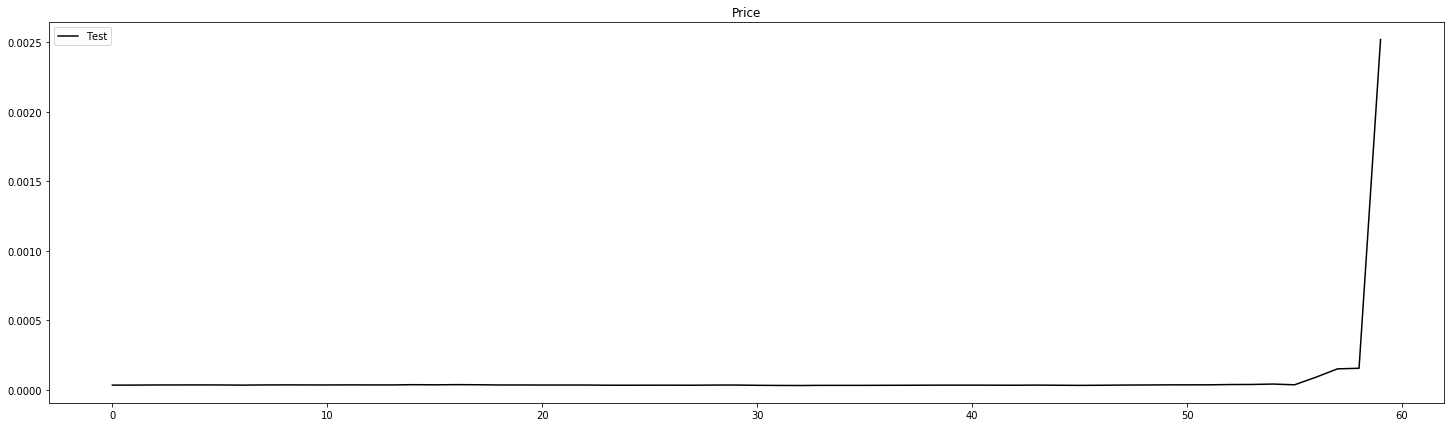

In [7]:
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
plt.figure(figsize=(25,7))
plt.plot(prices,label='Test',color='black')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [8]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],12,26,9)

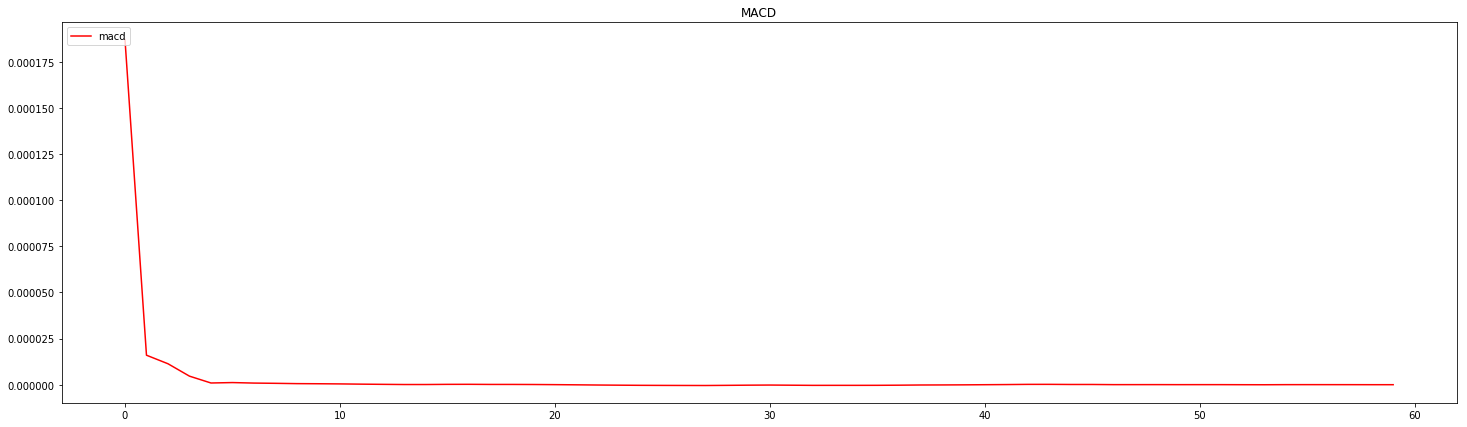

In [9]:
plt.figure(figsize=(25,7))
plt.plot(macd,label='macd',color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [10]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

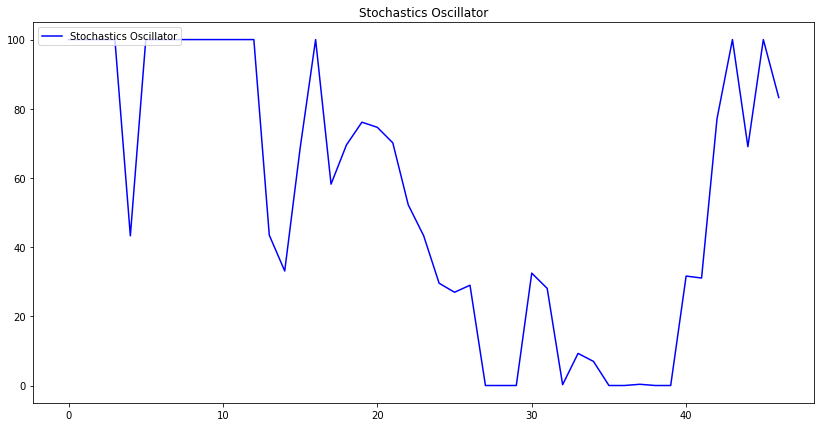

In [11]:
plt.figure(figsize=(14,7))
#First 100 points because it's too dense
plt.plot(stochastics[0:100],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='upper left')
plt.show()

### Average True Range

In [12]:
atr = ATR(df.iloc[len(df.index)-60:len(df.index)],14)

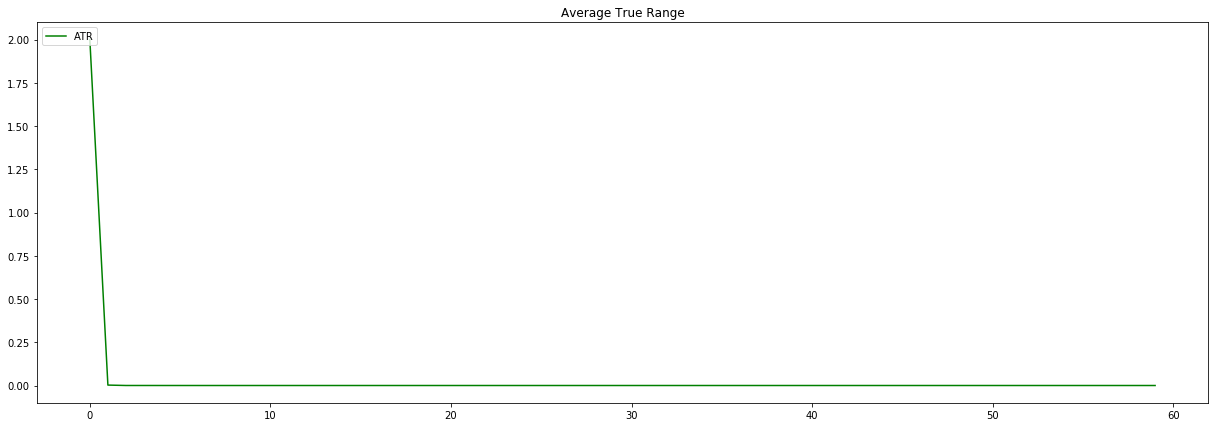

In [13]:
plt.figure(figsize=(21,7))
#First 100 points because it's too dense
plt.plot(atr[0:100],label='ATR',color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [14]:
dfPriceShift = dfPrices.shift(-1)
dfPriceShift.rename(columns={'Price':'PriceTarget'}, inplace=True)

dfPriceShift.head(2)

,PriceTarget
1999,0.000036
1998,0.000036


In [15]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Price':'MACD'}, inplace=True)

In [16]:
stochastics = stochastics_oscillator(dfPrices,14)
stochastics.rename(columns={'Price':'Stochastics'}, inplace=True)

In [17]:
atr = ATR(df,14)
atr.rename(columns={0:'ATR'}, inplace=True)

In [18]:
final_data = pd.concat([dfPrices,dfPriceShift,macd,stochastics,atr], axis=1)
# Delete the entries with missing values (where the stochastics couldn't be computed yet) 
# because have a lot of datapoints ;)
final_data = final_data.dropna()

final_data.info()
dfPrices.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 1986 to 1
Data columns (total 5 columns):
Price          1986 non-null float64
PriceTarget    1986 non-null float64
MACD           1986 non-null float64
Stochastics    1986 non-null float64
ATR            1986 non-null float64
dtypes: float64(5)
memory usage: 93.1 KB


,Price
1999,0.000037
1998,0.000036


In [19]:
final_data

,Price,PriceTarget,MACD,Stochastics,ATR
1986,0.000036,0.000036,-1.308299e-08,23.157895,1.000000e-08
1985,0.000036,0.000036,-6.009042e-09,36.666667,1.000000e-08
1984,0.000036,0.000036,-1.182152e-10,38.333333,1.300000e-07
1983,0.000036,0.000036,4.258097e-09,38.333333,0.000000e+00
1982,0.000036,0.000036,7.469430e-09,44.230769,2.000000e-08
1981,0.000036,0.000036,1.602088e-08,65.384615,1.300000e-07
1980,0.000036,0.000036,1.415824e-08,48.837209,1.400000e-07
1979,0.000036,0.000036,1.273713e-08,61.764706,2.300000e-07
1978,0.000036,0.000036,2.536719e-08,100.000000,2.400000e-07
1977,0.000036,0.000036,3.472748e-08,100.000000,2.000000e-08


In [20]:
final_data.to_csv('../input/BTC'+currency+'_techIndicators.csv',index=False)